## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Functions

In [3]:
def get_data (path):
    '''
    Returns the dataset.
    '''
    df = pd.read_csv(path)
    df.head()
    df.rename(columns = {'price':'buying_price'}, inplace = True)
    return df

def percentage_growth(data):
    '''
    Returns the percentage growth of the second value compared to the first one.
    '''
    answer = (data.iloc[1, 1] * 100 / data.iloc[0, 1]) - 100
    return answer

## Get data

In [4]:
path = 'kc_house_data.csv'
data = get_data(path)

## Data Visualization and Filtering

In [5]:
# dropping a line I know is a outlier
data = data.drop(data.index[15870])

In [6]:
# data columns visualization for names
data.columns

Index(['id', 'date', 'buying_price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [23]:
# set float configuration
pd.set_option('display.float_format', lambda x: '%.2f' % x)

***
## Insights Validation
Here i will check the insights veracity and explain its results one by one.

### Hypotesis 01:
Water view properties are, at least, 20% more expensive, on avarege.

In [7]:
# group the prices means by waterfront (0 = nowaterview; 1 = has waterview)
price_waterview = data[['buying_price', 'waterfront']].groupby('waterfront').mean().reset_index()

# calculate the percentage difference of waterview prices over non-waterview prices
x = percentage_growth(price_waterview)

# print the answers
price_waterview.rename(columns = {'buying_price':'buying_price_mean'}, inplace = True)
print(f'Properties with water view are {x:.2f}% more expensive, on avarege')
print(price_waterview.to_markdown())
price_waterview

Properties with water view are 212.64% more expensive, on avarege
|    |   waterfront |   buying_price_mean |
|---:|-------------:|--------------------:|
|  0 |            0 |    531559           |
|  1 |            1 |         1.66188e+06 |


,waterfront,buying_price_mean
0,0,531558.54
1,1,1661876.02


### Hypotesis 01 Answer:
**True:** Properties with water view are 212.63% more expensive, on avarege.


****

### Hypotesis 02:
Properties built before 1955 are more than 50% cheaper, on avarege.


In [12]:
# get the prices before 1955
before_year = data.loc[(data['yr_built'] < 1955), ['yr_built', 'buying_price']
        ].groupby('yr_built').mean().reset_index()

# get the mean of the before-1955 prices
mean_before = before_year['buying_price'].mean()

# get the prices after 1955
after_year = data.loc[(data['yr_built'] >= 1955), ['yr_built', 'buying_price']
        ].groupby('yr_built').mean().reset_index()

# get the mean of the before-1955 prices
mean_after = after_year['buying_price'].mean()

# get the percentage difference (result)
percentage = (((mean_after * 100) / mean_before) - 100) * -1

# print the result
before_year.rename(columns = {'buying_price_mean':'price_mean_year'}, inplace = True)
print(f' The properties built before 1955 are, actually, {percentage:.2f}% more expensive, on avarage')
print(before_year.sample(10).to_markdown())
before_year.sample(10)


 The properties built before 1955 are, actually, 4.47% more expensive, on avarage
|    |   yr_built |   buying_price |
|---:|-----------:|---------------:|
| 53 |       1953 |         490423 |
| 46 |       1946 |         524641 |
| 25 |       1925 |         607219 |
| 28 |       1928 |         621714 |
| 32 |       1932 |         458409 |
|  5 |       1905 |         752978 |
| 50 |       1950 |         490506 |
| 51 |       1951 |         545029 |
| 52 |       1952 |         530437 |
| 10 |       1910 |         671536 |


,yr_built,buying_price
4,1904,583756.64
24,1924,570391.15
31,1931,661617.21
11,1911,632488.36
16,1916,600915.04
8,1908,564348.69
40,1940,576119.49
23,1923,618475.20
1,1901,556935.93
41,1941,526612.01


### Hypotesis 02 Answer:
**False**: The properties built before 1955 are, actually, 4.46% more expensive, on avarage

****

### Hypothesis 03:
Properties without a basement have a total area, at least, 40% larger than properties with basement, on avarage.

In [13]:
# get a copy of the dataset
df1 = data[['sqft_basement', 'sqft_lot']].copy()

# create 'has_basement' column (boolean)
df1['has_basement'] = df1['sqft_basement'].apply(lambda x: True if x != 0 else False)
df1 = df1[['sqft_lot', 'has_basement']].groupby('has_basement').mean().reset_index()

# calculate the percentage difference
# properties without basement = 100%
# properties with basement = x (81.59%)
x = percentage_growth(df1)

# 100 - 81.59 is the size difference on avarage
df1.rename(columns = {'sqft_lot':'sqft_lot_mean'}, inplace = True)
print(f'Properties with basement, are {x:.2f}% larger than the ones without one, on avarage')
print(df1.to_markdown())
df1

Properties with basement, are -18.40% larger than the ones without one, on avarage
|    | has_basement   |   sqft_lot_mean |
|---:|:---------------|----------------:|
|  0 | False          |         16284.2 |
|  1 | True           |         13287.2 |


,has_basement,sqft_lot_mean
0,False,16284.18
1,True,13287.15


### Hypothesis 03 Answer:

**False**: Properties without basement are 18.41% larger than the ones with basement, on avarage


****

### Hypothesis 04:
The property price growth YoY (Year over Year) is more than 10%.

**False**: The price percentage growth of 2015 over 2014 is 0.52%

The price percentage growth of 2015 over 2014 is 0.52%


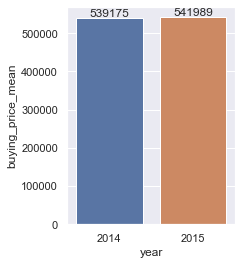

In [22]:
# set year column based on date column
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['year'] = data['date'].dt.year

# group price means by year
df = data[['year','buying_price']].groupby('year').mean().reset_index()

# get the growth percentage YoY
YoY_price = percentage_growth(df)
df.rename(columns = {'buying_price':'buying_price_mean'}, inplace = True)
print(f'The price percentage growth of 2015 over 2014 is {YoY_price:.2f}%')

# plot the buying price mean per year graph
plt.figure(figsize = (3, 4))
# sns.set_theme(style="darkgrid")
ax = sns.barplot(x='year', y='buying_price_mean', data=df);
ax.bar_label(ax.containers[0]);

### Hypothesis 04 Answer:
**False**: The price percentage growth of 2015 over 2014 is 0.52%

****

### Hypothesis 05 :
Properties with 3 bathrooms have a price growth of more than 15% per month, on avarage.

Properties with 3 bathrooms have a price growth of 0.32% per month, on avarage.
|    |   year |   month |   buying_price_mean | date                |      growth |
|---:|-------:|--------:|--------------------:|:--------------------|------------:|
|  0 |   2014 |       5 |              690081 | 2014-10-13 00:00:00 |   0         |
|  1 |   2014 |       6 |              775058 | 2014-12-09 00:00:00 | -10.9639    |
|  2 |   2014 |       7 |              741405 | 2015-02-25 00:00:00 |   4.53902   |
|  3 |   2014 |       8 |              737577 | 2014-12-09 00:00:00 |   0.519062  |
|  4 |   2014 |       9 |              645247 | 2015-02-18 00:00:00 |  14.3092    |
|  5 |   2014 |      10 |              645523 | 2014-05-12 00:00:00 |  -0.0427758 |
|  6 |   2014 |      11 |              679910 | 2014-06-27 00:00:00 |  -5.05764   |
|  7 |   2014 |      12 |              728341 | 2015-01-15 00:00:00 |  -6.64946   |
|  8 |   2015 |       1 |              672923 | 2015-04-15 00:00:00 |   8.23542 

,year,month,buying_price_mean,date,growth
0,2014,5,690080.71,2014-10-13,0.00
1,2014,6,775057.56,2014-12-09,-10.96
2,2014,7,741405.04,2015-02-25,4.54
3,2014,8,737576.56,2014-12-09,0.52
4,2014,9,645246.89,2015-02-18,14.31
5,2014,10,645523.02,2014-05-12,-0.04
6,2014,11,679910.47,2014-06-27,-5.06
7,2014,12,728341.19,2015-01-15,-6.65
8,2015,1,672923.17,2015-04-15,8.24
9,2015,2,696714.42,2015-03-12,-3.41


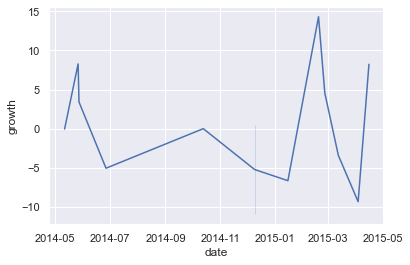

In [21]:
# create 'month' and 'year' columns
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# set a dataset with the month, year and mean price of the 3 bathrooms properties
df = data.loc[data['bathrooms'] == 3, ['year', 'month', 'buying_price']
        ].groupby(['year', 'month']
                 ).mean().reset_index()
df['date'] = data['date'].copy()

# create the 'growth' column ( growth of the price mean compared to the last month in percentage)
for l in range(len(df)):
    if l == 0:
        df.loc[l, 'growth'] = 0
    else:
        df.loc[l, 'growth'] = ((df.loc[ 
            (l-1), 'buying_price' 
        ] * 100) / df.loc[
            l, 'buying_price'
        ]) - 100

# the result is the mean of all the growth percentages per month
result = df.iloc[1:, 4].mean()
df.rename(columns = {'buying_price':'buying_price_mean'}, inplace = True)
print(f'Properties with 3 bathrooms have a price growth of {result:.2f}% per month, on avarage.')

# plot a graph of the growth per month
sns.lineplot(x = 'date', y = 'growth', data = df);
print(df.to_markdown())
df

### Hypothesis 05 Answer:
**FALSE**: Properties with 3 bathrooms have a price growth of 0.32% per month, on avarage.

****

# Financial Results for the company